---
title: "Diversifying Search Results with Pyversity and Qdrant"
description: "Diversifying search results with Qdrant and Pyversity for better RAG System with MMR, DDP and other algorthims"
author: "kareem"
date: 2025-12-15
format:
  html:
    code-fold: false
    code-tools: true
    toc: true
    toc-depth: 3
categories:
    - blogging
    - minishlab
    - embedding
    - qdrant 
    - til 
image: "images/minishlab.jpg"
draft: false
execute: 
    echo: false
jupyter: python3
---


## Why Diversify Search Results?

While building a real-estate search engine using RAG (Retrieval-Augmented Generation) across multiple collections, we hit an interesting problem: our top results were often too similar.

**Example scenario:**
- User query: "I want a unit in New Cairo"
- Top 5 results: 3 units from Palm Hills, 1 from Sodic, 1 from Radix

The issue? Our agent's responses became heavily skewed toward Palm Hills properties, leading customers to believe we were manipulating results to favor specific developers.

**The solution:** Diversification algorithms like MMR (Maximal Marginal Relevance) help balance relevance with variety. 

I found the amazing  [Pyversity](https://github.com/Pringled/pyversity) - a lightweight Python library that implements multiple diversification strategies.

In this post, we'll explore:
1. What Pyversity offers and how it works
2. Qdrant's built-in MMR capabilities
3. Combining Pyversity with Qdrant for flexible diversification


## Meet Pyversity: Your Diversification Toolkit

Pyversity is a lightweight library that solves a common problem: search results that all look the same. It re-ranks your results to surface items that are relevant *and* different from each other.

What makes it special?
- **Multiple strategies**: MMR, MSD, DPP, COVER, and SSD - each with different strengths
- **Minimal dependencies**: Just NumPy
- **Simple API**: One function to rule them all

Let's see it in action with a quick example.


In [ ]:
#| echo: true
import numpy as np
from pyversity import diversify, Strategy

# Define embeddings and scores (e.g. cosine similarities of a query result)
embeddings = np.random.randn(100, 256)
scores = np.random.rand(100)

# Diversify the result
diversified_result = diversify(
    embeddings=embeddings,
    scores=scores,
    k=10, 
    strategy=Strategy.MMR,
    diversity=0.5 # Diversity parameter (higher values prioritize diversity)
)


print("Diversified Indices:\n", diversified_result.indices)
print("\nSelection Scores:\n", diversified_result.selection_scores)
print("\nStrategy Used:", diversified_result.strategy)

Diversified Indices:
 [66 16 20 34 54 89 53 81 24 42]

Selection Scores:
 [0.4990284  0.49552712 0.49322212 0.4734265  0.44911325 0.44692624
 0.4468549  0.43787128 0.4272018  0.4173287 ]

Strategy Used: Strategy.MMR


## Diversification Strategies

| Strategy | What It Does | Time Complexity | Best For |
|----------|-------------|-----------------|----------|
| **MMR** | Balances relevance with dissimilarity to already-selected items | O(k·n·d) | General purpose - fast and effective |
| **MSD** | Maximizes distance from *all* previous selections | O(k·n·d) | Broader topic coverage |
| **DPP** | Probabilistic sampling with built-in "repulsion" | O(k·n·d + n·k²) | Eliminating redundancy |
| **COVER** | Ensures selections represent the full dataset structure | O(k·n²) | Topic clustering (slower for large datasets) |
| **SSD** | Sequence-aware: rewards novelty relative to recent items | O(k·n·d) | Content feeds, infinite scroll, conversational RAG |


## Qdrant MMR in Action

Qdrant has built-in MMR support that helps diversify visual search results. 

Let's test it with a fashion dataset - we'll search for "black jacket" and compare standard search (which might return very similar items) against MMR search (which balances relevance with variety).

We'll use the DeepFashion dataset with CLIP embeddings for visual similarity.

In the end, we will use pyversity with Qdrant


In [74]:
from datasets import load_dataset
from fastembed import ImageEmbedding, TextEmbedding
from qdrant_client import QdrantClient, models
import uuid


In [2]:

def load_fashion_data(sample_size=10):
    """Load fashion items from DeepFashion-with-masks dataset"""
    dataset = load_dataset("SaffalPoosh/deepFashion-with-masks", split="train")
    sample_dataset = dataset.shuffle(seed=42).select(range(sample_size))
    
    fashion_items = []
    for i, item in enumerate(sample_dataset):
        if item['gender']=="WOMEN":
            continue    

            
        metadata = {}
        for key, value in item.items():
            if key not in ["images", "mask", "mask_overlay"] and value is not None :
                metadata[key] = value
        
        fashion_items.append({
            "image": item["images"],  # PIL Image object
            **metadata
        })
    
    return fashion_items

fashion_items = load_fashion_data(sample_size=10000)

### Creating Fashion Embedding 

In [3]:
# Create image embeddings for all fashion items
image_model = ImageEmbedding(model_name="Qdrant/clip-ViT-B-32-vision")
embeddings = list(image_model.embed([item["image"] for item in fashion_items]))

In [ ]:
#| include: false

client = QdrantClient(host="localhost", port=6333)
collection_name="fashion_discovery"

client.recreate_collection(
    collection_name=collection_name,
    vectors_config=models.VectorParams(
        size=512,
        distance=models.Distance.COSINE
    )
)



points = []
for i, (item, embedding) in enumerate(zip(fashion_items, embeddings)):
    # Remove PIL image from payload
    payload = {k: v for k, v in item.items() if k != "image"}
    payload["item_id"] = i
    
    point = models.PointStruct(
        id=str(uuid.uuid4()),
        vector=embedding.tolist(),
        payload=payload
    )
    points.append(point)

client.upsert(collection_name=collection_name, points=points)


/tmp/ipykernel_101661/1455556917.py:4: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  client.recreate_collection(


UpdateResult(operation_id=0, status=<UpdateStatus.COMPLETED: 'completed'>)

In [ ]:
#| echo: true
def fashion_search_standard(query_text, limit=5):
    text_model = TextEmbedding(model_name="Qdrant/clip-ViT-B-32-text")
    query_embedding = list(text_model.embed([query_text]))[0]
    
    results = client.query_points(
        collection_name=collection_name,
        query=query_embedding.tolist(),
        limit=limit,
        with_payload=True
    )
    return results
    




In [76]:
query_text = " black jacket"
standard_results = fashion_search_standard(query_text)




STANDARD FASHION SEARCH: 'black jacket'



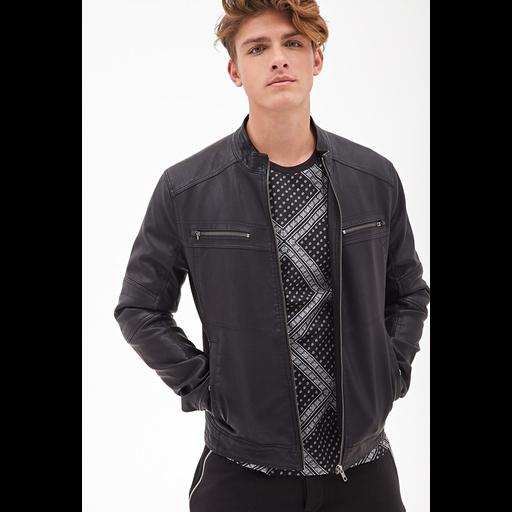
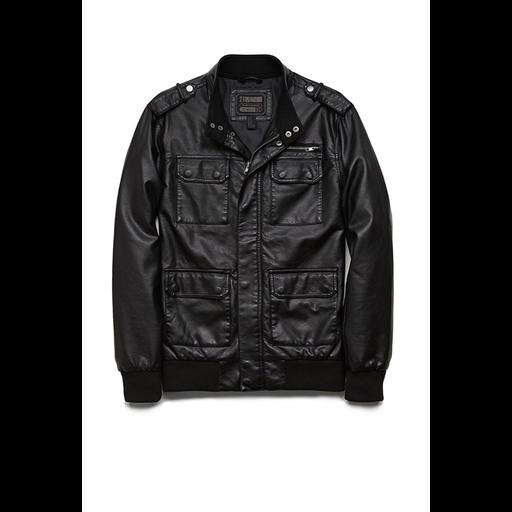
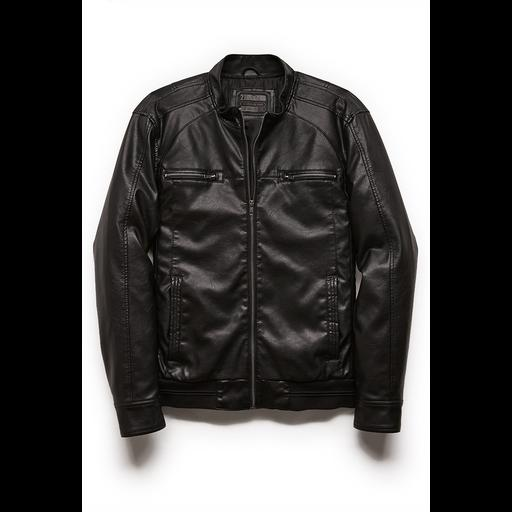
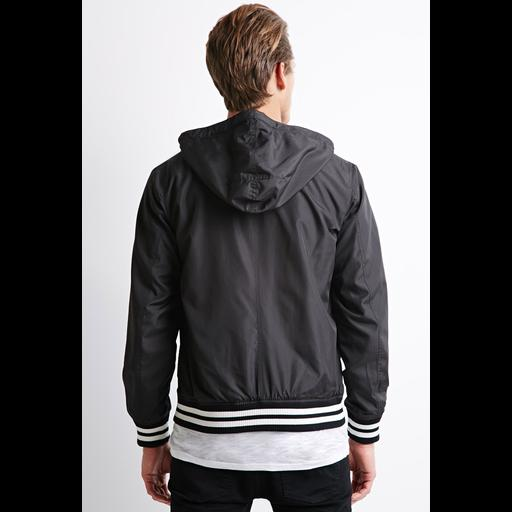
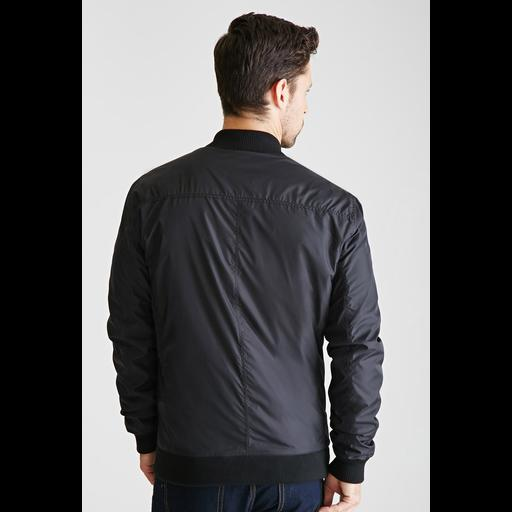

In [77]:
print("\nSTANDARD FASHION SEARCH: 'black jacket'")

def display_standard_results(results, query_text):
    html = f"""
    <div style="font-family: system-ui, sans-serif; margin: 40px 0;">
        <h2 style="color: #dc2626; border-bottom: 3px solid #ef4444; padding-bottom: 10px;">
            Standard Search Results for "<i>{query_text}</i>"
        </h2>
        <div style="display: grid; 
                    grid-template-columns: repeat(auto-fit, minmax(280px, 1fr)); 
                    gap: 28px; 
                    padding: 20px 0;">
    """
    
    for i, point in enumerate(results.points, 1):
        payload = point.payload
        img = fashion_items[payload['item_id']]['image']
        
        # Convert image to base64
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        
        caption = payload.get('caption', 'No caption available')
        cloth_type = payload.get('cloth_type', 'Unknown').replace('_', ' & ')
        score = point.score
        
        html += f"""
        <div style="background:#fff; border-radius:16px; overflow:hidden; 
                    box-shadow:0 12px 30px rgba(0,0,0,0.12); 
                    transition: all 0.3s ease;"
             onmouseover="this.style.transform='translateY(-10px)'; this.style.boxShadow='0 20px 40px rgba(0,0,0,0.2)'"
             onmouseout="this.style.transform='translateY(0)'; this.style.boxShadow='0 12px 30px rgba(0,0,0,0.12)'">
            <img src="data:image/png;base64,{img_str}" 
                 style="width:100%; height:340px; object-fit:cover; display:block;">
            <div style="padding:18px;">
                <div style="font-weight:700; font-size:18px; color:#111827;">
                    #{i} • Score: {score:.3f}
                </div>
                <div style="margin:10px 0; color:#4b5563; line-height:1.5; font-size:15px;">
                    {caption}
                </div>
                <div style="color:#8b5cf6; font-weight:600; font-size:14px;">
                    {cloth_type}
                </div>
            </div>
        </div>
        """
    
    html += "</div></div>"
    display(HTML(html))


# Run it!
display_standard_results(standard_results, "black jacket")

### Standard Qdrant Search Results

Notice something? Most of these black jackets look very similar

Same style, similar cuts, nearly identical designs. 

While they're all highly relevant to our query, they don't give users much variety to choose from. 
This is exactly the problem diversification solves.
All scores ar around 0.288 to 0.278 very similar results 



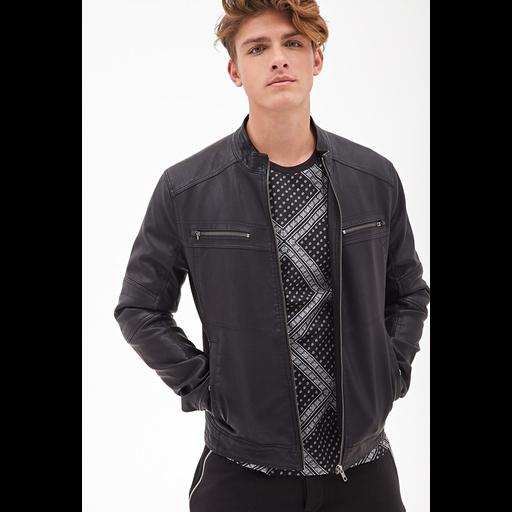
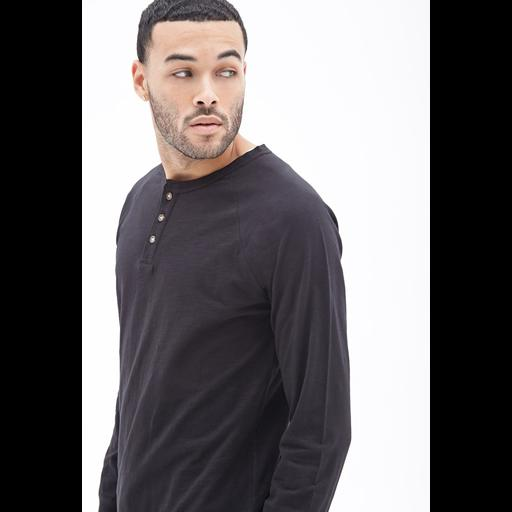
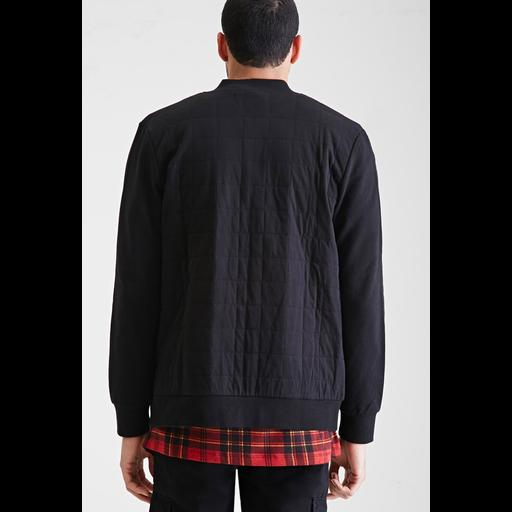
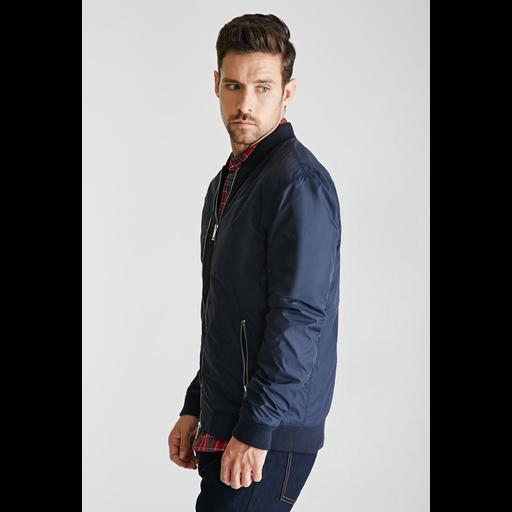
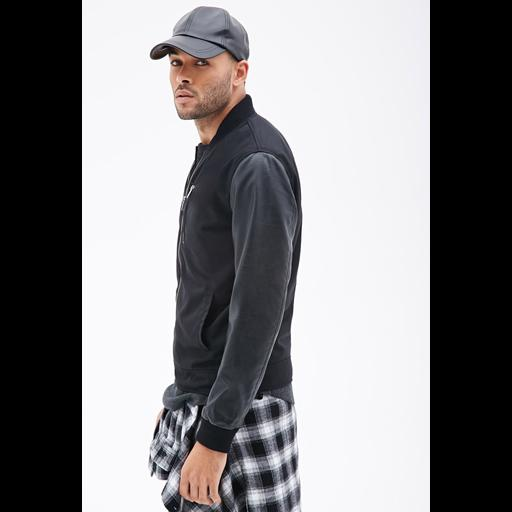
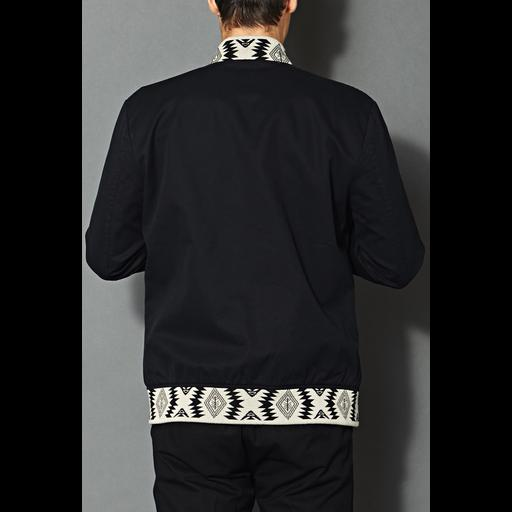

In [ ]:
#| echo: true

def fashion_search_mmr(query_text, limit=5, diversity=0.5):
    text_model = TextEmbedding(model_name="Qdrant/clip-ViT-B-32-text")
    query_embedding = list(text_model.embed([query_text]))[0]
    
    results = client.query_points(
        collection_name=collection_name,
        query=models.NearestQuery(
            nearest=query_embedding.tolist(),
            mmr=models.Mmr(
                diversity=diversity,  # 0.0 - relevance; 1.0 - diversity
                candidates_limit=100  # num of candidates to preselect
            )
        ),
        limit=limit,
        with_payload=True
    )
    return results


In [ ]:

query_text = "black jacket"

from IPython.display import display, HTML
import base64
from io import BytesIO

def display_fashion_results(results, query_text, title="Fashion Search Results"):
    html = f"""
    <div style="font-family: system-ui, sans-serif; margin: 30px 0;">
        <h2 style="color: #1e3a8a; border-bottom: 3px solid #3b82f6; padding-bottom: 10px;">
            {title}: "<i>{query_text}</i>"
        </h2>
        <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(280px, 1fr)); gap: 24px; padding: 20px 0;">
    """
    
    for i, point in enumerate(results.points, 1):
        payload = point.payload
        img = fashion_items[payload['item_id']]['image']
        
        # Convert PIL/np image to base64
        buffered = BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        
        caption = payload.get('caption', 'No caption')
        cloth_type = payload.get('cloth_type', 'Unknown')
        score = point.score
        
        html += f"""
        <div style="
            background: white; 
            border-radius: 16px; 
            overflow: hidden; 
            box-shadow: 0 10px 25px rgba(0,0,0,0.1);
            transition: transform 0.3s; 
            border: 1px solid #e2e8f0;"
            onmouseover="this.style.transform='translateY(-8px)'"
            onmouseout="this.style.transform='translateY(0)'">
            
            <img src="data:image/png;base64,{img_str}" style="width:100%; height:320px; object-fit: cover;">
            
            <div style="padding: 16px;">
                <div style="font-weight: bold; font-size: 17px; color: #1f2937;">#{i} • Score: {score:.3f}</div>
                <div style="margin: 8px 0; color: #4b5563; line-height: 1.5;">{caption}</div>
                <div style="font-size: 14px; color: #6366f1; font-weight: 600;">
                    {cloth_type.replace('_', ' & ')}
                </div>
            </div>
        </div>
        """
    
    html += "</div></div>"
    display(HTML(html))

# Use it!
query_text = "black jacket"
mmr_results = fashion_search_mmr(query_text, limit=6, diversity=0.5)

display_fashion_results(mmr_results, query_text, "MMR Search – Diverse Black Jackets")



### MMR Search - Diversity in Action

Look at the difference! Instead of six nearly-identical black jackets, MMR gives us real variety: formal wear with ties, casual tees, layered looks, even a blue jacket and styled outfits with patterned pants. 

Yes, some scores dropped slightly - but the browsing experience? Much better. Users can actually explore different styles instead of scrolling through clones.


## Pyversity with Qdrant
Let's try to use the Pyversity algorhtims with Qdrant engine


In [ ]:
#| echo: true
def apply_pyversity(qdrant_results, strategy=Strategy.MMR, k=10, **strategy_kwargs):
    """Apply Pyversity diversification to Qdrant search results"""
    embeddings = np.array([point.vector for point in qdrant_results.points])
    scores = np.array([point.score for point in qdrant_results.points])
    
    diversified = diversify(
        embeddings=embeddings,
        scores=scores,
        k=k,
        strategy=strategy,
        **strategy_kwargs
    )
    
    # Return reordered results based on diversified indices
    return [qdrant_results.points[i] for i in diversified.indices], diversified



In [ ]:
#| echo: true
def diversified_search(client, collection_name, query_embedding, 
                       strategy=Strategy.MMR, k=10, 
                       candidates_limit=100, **strategy_kwargs):
    """Search Qdrant and apply Pyversity diversification"""
    results = client.query_points(
        collection_name=collection_name,
        query=query_embedding.tolist(),
        limit=candidates_limit,
        with_payload=True,
        with_vectors=True
    )
    
    # This should return the tuple from apply_pyversity
    return apply_pyversity(results, strategy=strategy, k=k, **strategy_kwargs)



Testing MMR Strategy



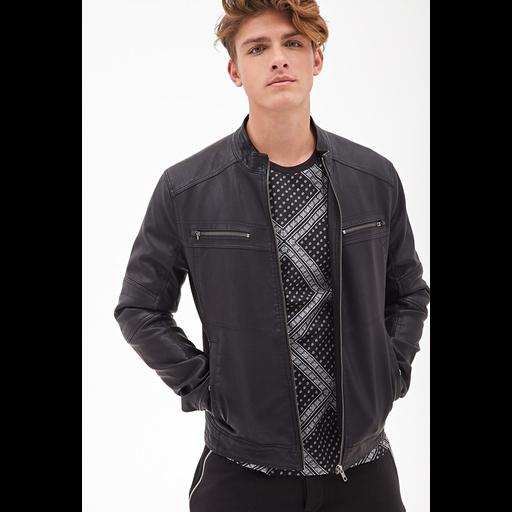
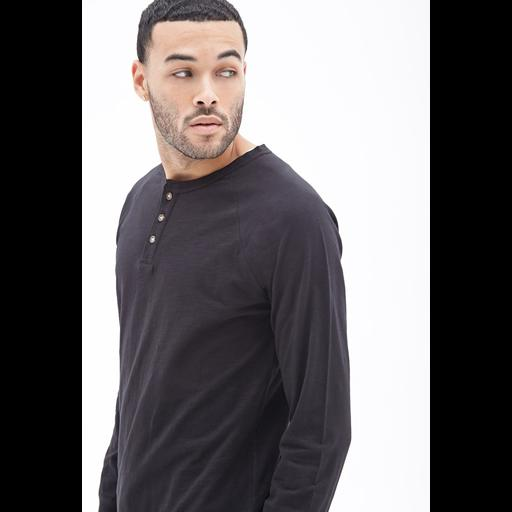
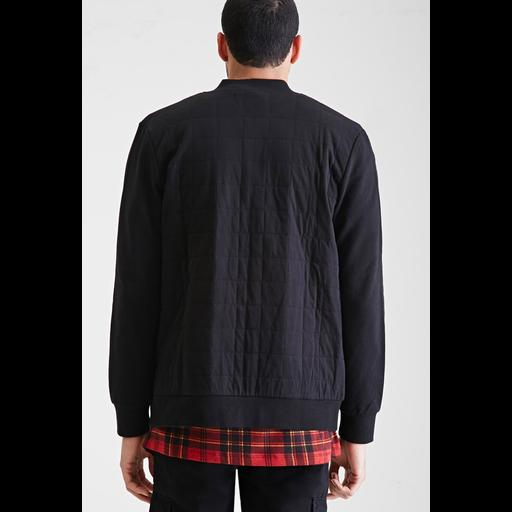
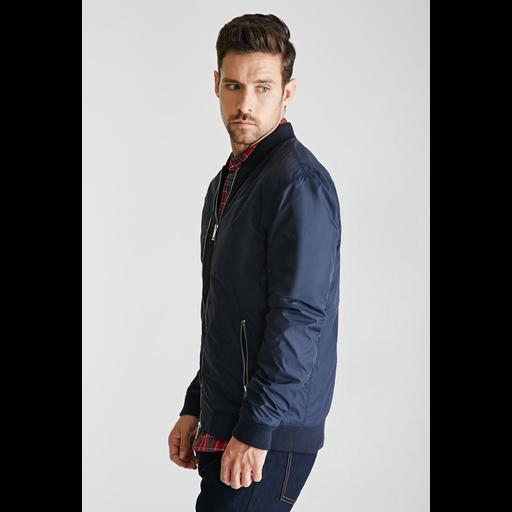
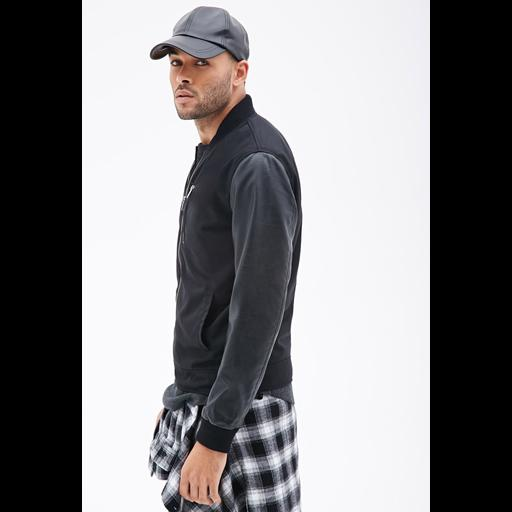
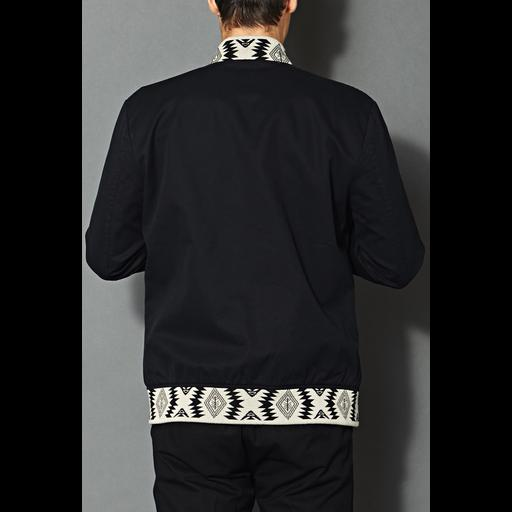


Diversity Stats:
Strategy: Strategy.MMR
Selection Scores: [ 0.1440569  -0.21647353 -0.23149979 -0.23982394 -0.2528901  -0.2622754 ]

Testing MSD Strategy



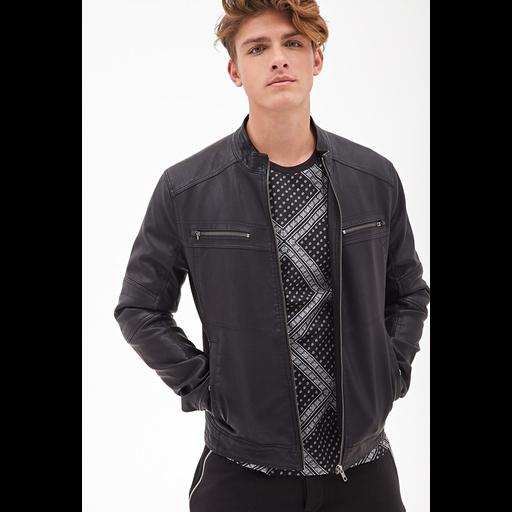
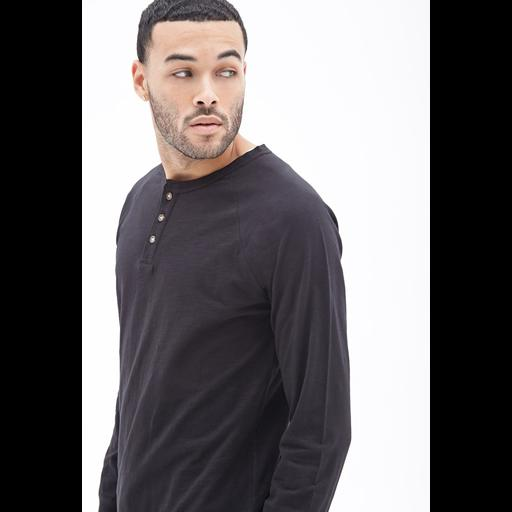
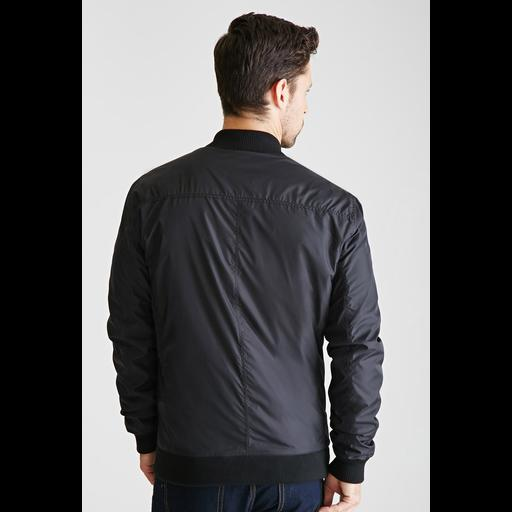
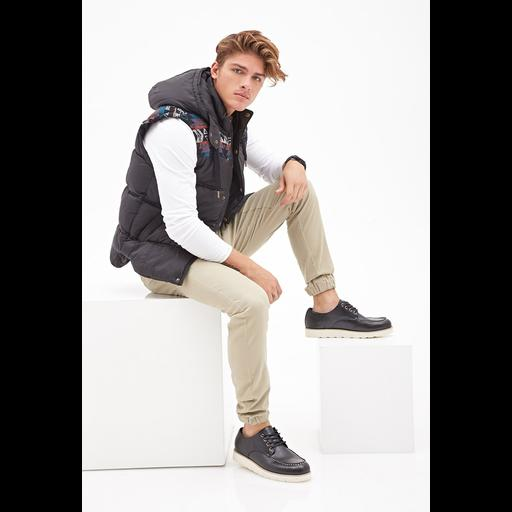
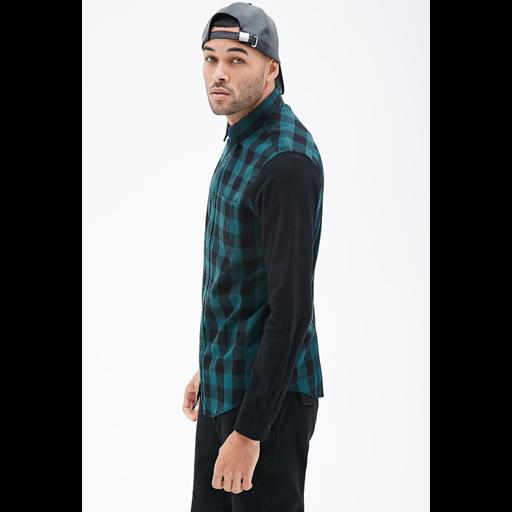
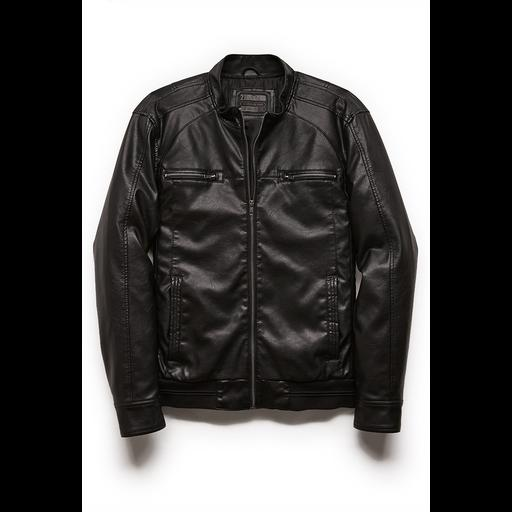


Diversity Stats:
Strategy: Strategy.MSD
Selection Scores: [0.1440569  0.28352648 0.45831633 0.5803725  0.7433619  0.9287865 ]

Testing DPP Strategy



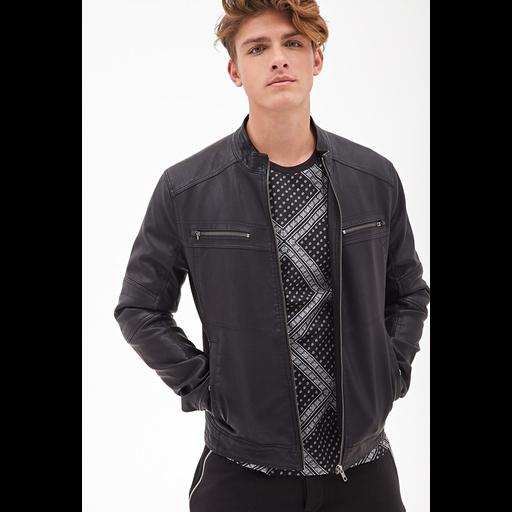
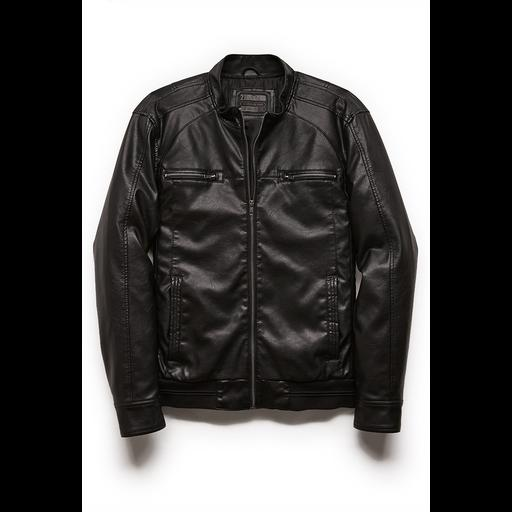
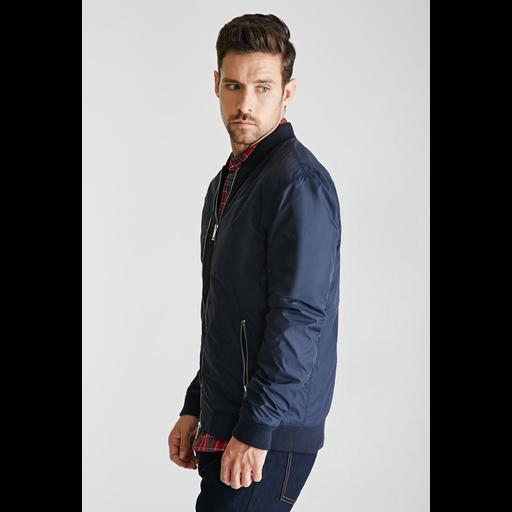
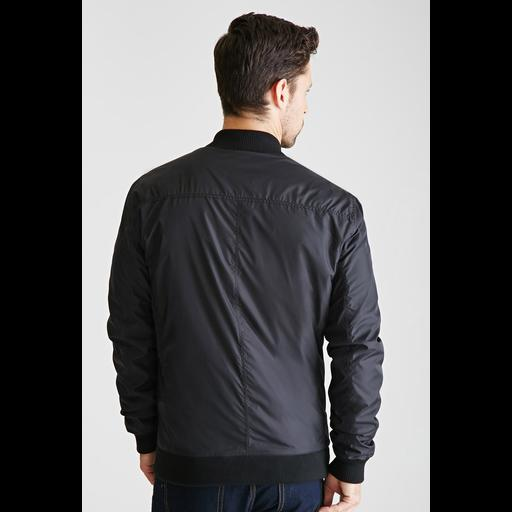
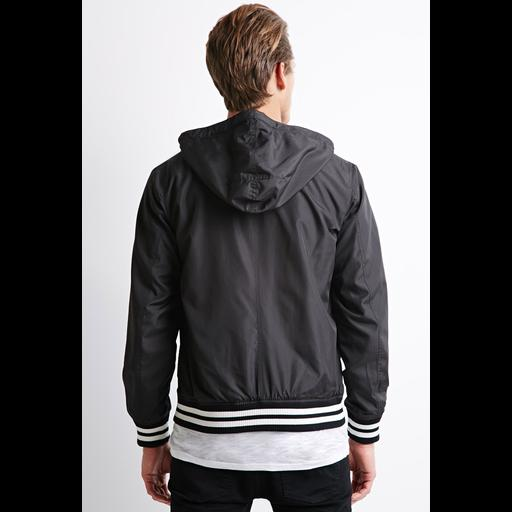
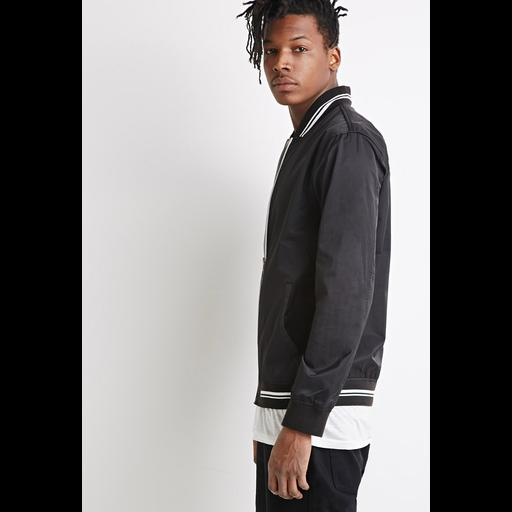


Diversity Stats:
Strategy: Strategy.DPP
Selection Scores: [11.763905   4.50202    1.778986   1.6289598  1.1995786  1.063326 ]

Testing COVER Strategy



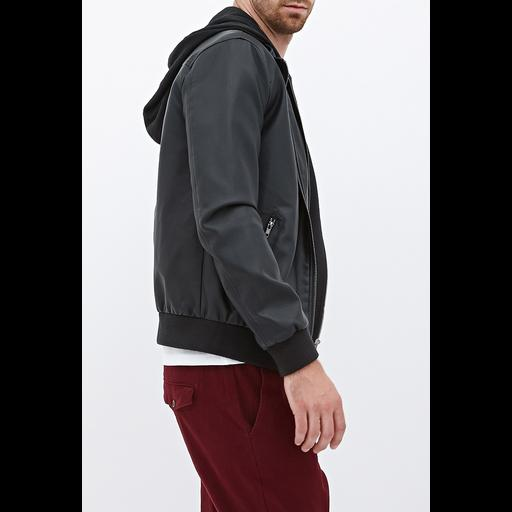
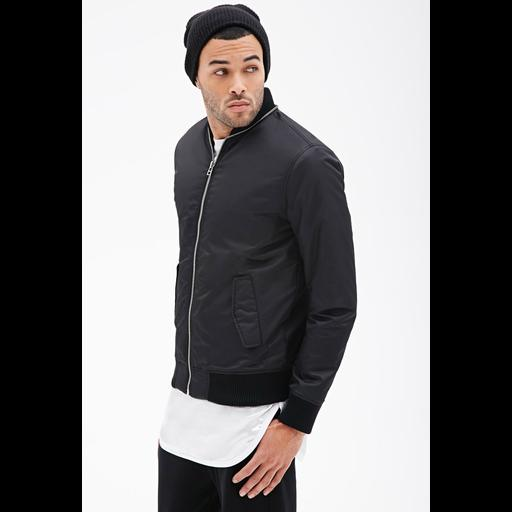
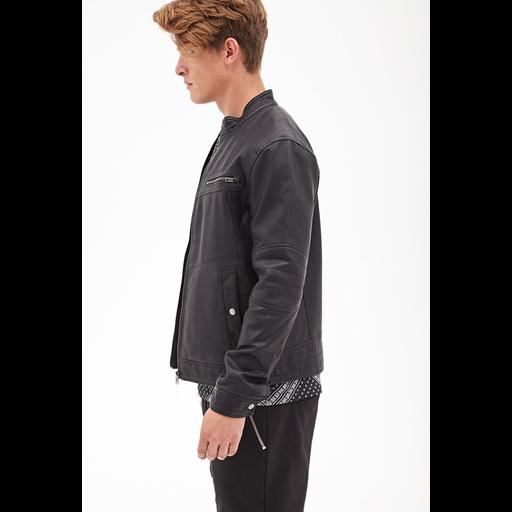
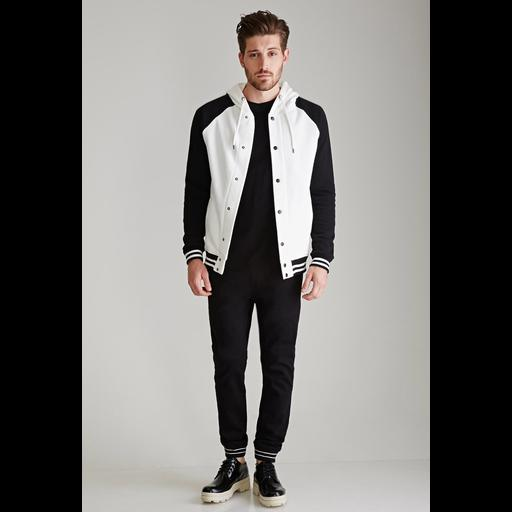
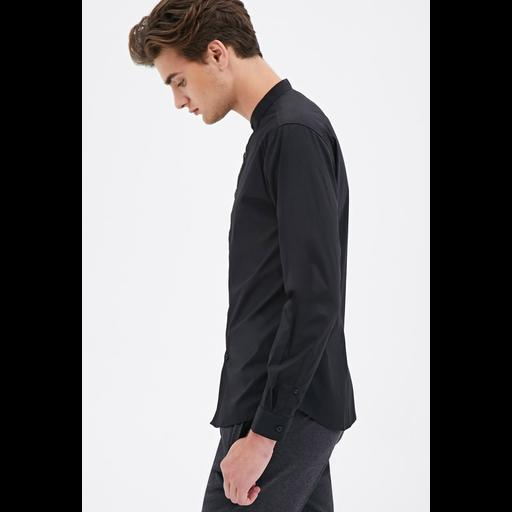
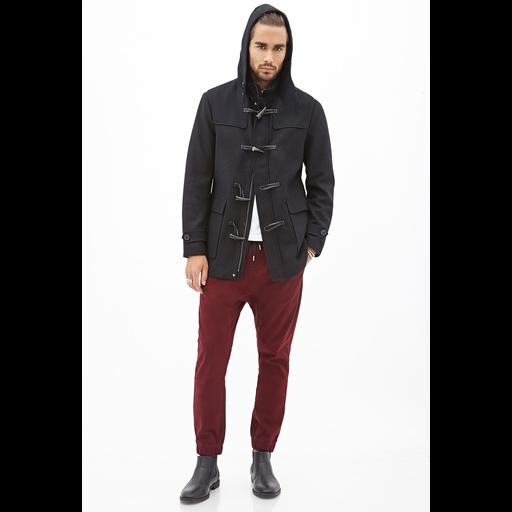


Diversity Stats:
Strategy: Strategy.COVER
Selection Scores: [45.971733  19.065933  14.6605215 12.34475   10.894392   9.850458 ]

Testing SSD Strategy



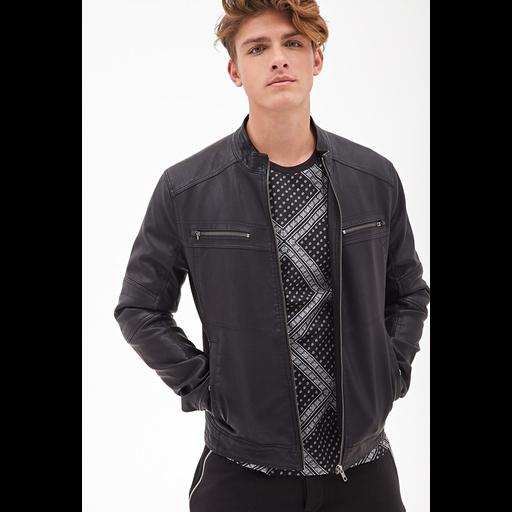
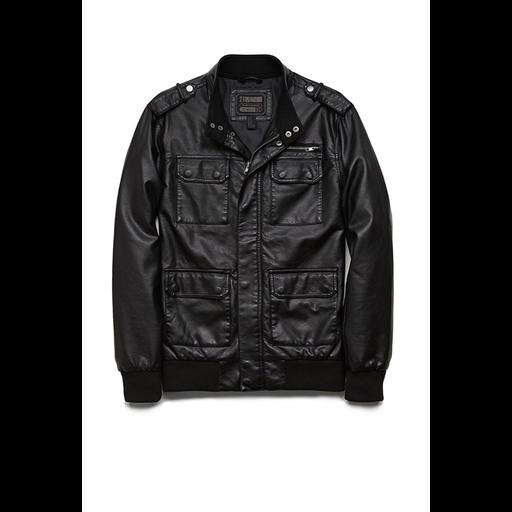
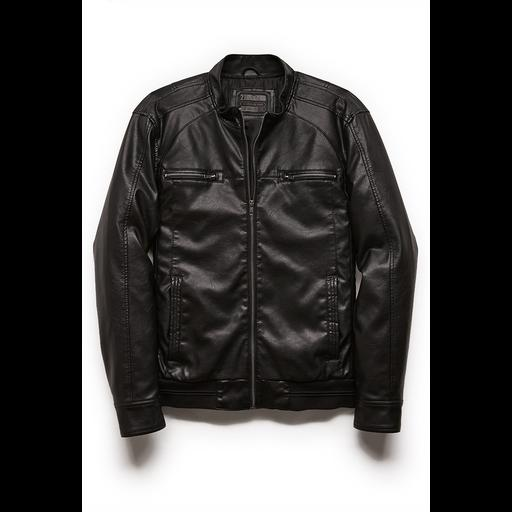
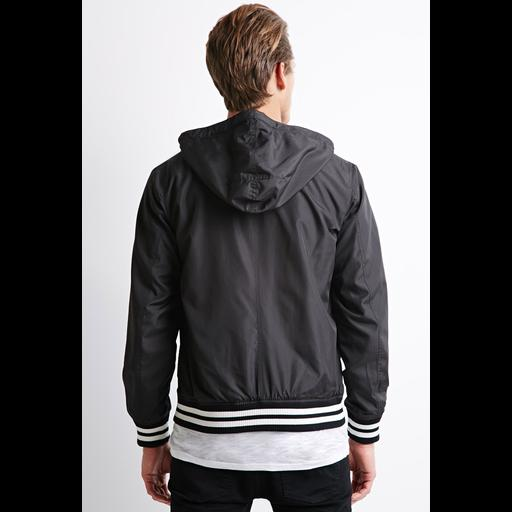
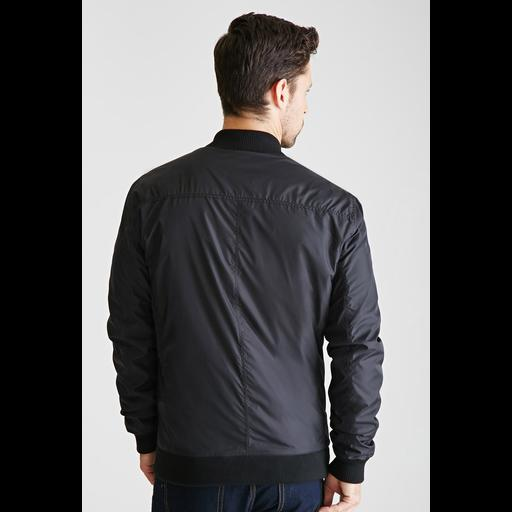
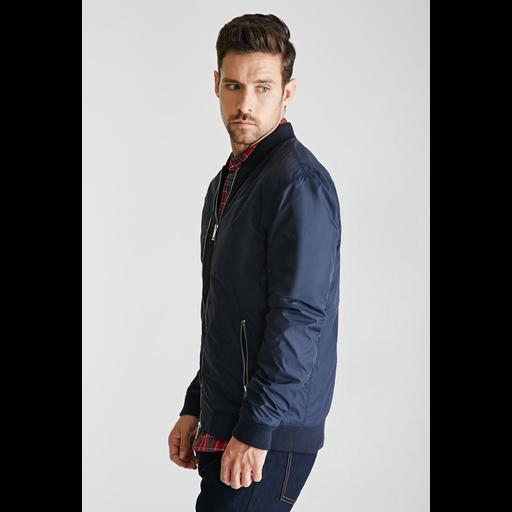


Diversity Stats:
Strategy: Strategy.SSD
Selection Scores: [1.939636  1.524907  1.3047718 1.2576772 1.1047928 1.0550355]


In [90]:
# Get query embedding once
text_model = TextEmbedding(model_name="Qdrant/clip-ViT-B-32-text")
query_text = "black jacket"
query_embedding = list(text_model.embed([query_text]))[0]

# Test all strategies
strategies = {
    "MMR": Strategy.MMR,
    "MSD": Strategy.MSD,
    "DPP": Strategy.DPP,
    "COVER": Strategy.COVER,
    "SSD": Strategy.SSD
}

for name, strategy in strategies.items():
    print(f"\n{'='*60}")
    print(f"Testing {name} Strategy")
    print('='*60)
    
    points, diversity_result = diversified_search(
        client=client,
        collection_name=collection_name,
        query_embedding=query_embedding,
        strategy=strategy,
        k=6,
        candidates_limit=100
    )
    
    # Create a mock results object for display
    class MockResults:
        def __init__(self, points):
            self.points = points
    
    mock_results = MockResults(points)
    display_fashion_results(mock_results, query_text, f"{name} Strategy")
    
    print(f"\nDiversity Stats:")
    print(f"Strategy: {diversity_result.strategy}")
    print(f"Selection Scores: {diversity_result.selection_scores}")


## Comparing Diversification Strategies

After testing all five strategies on our fashion search, here's what we observed:

**MMR & MSD**: Both provided good variety while maintaining relevance. MMR tends to be slightly faster and is a solid default choice. MSD pushes for even more spread across different styles.

**DPP**: Offers probabilistic diversity with a natural balance. Great when you want to eliminate near-duplicates while keeping results feeling "organic."

**COVER**: Ensures broad coverage across the dataset. Best when you need to represent different clusters or categories, though it's slower on large datasets.

**SSD**: Sequence-aware diversification. Perfect for feeds where users scroll through results over time - it avoids showing similar items close together.

****

Start with MMR for general use. Experiment with others based on your specific needs.


## The Diversity vs. Relevance Trade-off

Diversification isn't free - there's always a balance:

**Score drops**: Notice how diversified results sometimes have lower similarity scores? That's expected. We're trading pure relevance for variety.

**Computational cost**: Fetching 100 candidates and diversifying to 10 is slower than just grabbing the top 10. But for most applications, the added latency (milliseconds) is worth the improved user experience.

**Sweet spot**: In our tests, fetching 100 candidates and diversifying to 5-10 results gave the best balance. Too few candidates limits diversity options; too many adds unnecessary overhead.

**The payoff**: Better user engagement, reduced bias, and more satisfied customers who feel they're seeing real choices.


## References
1. [Qdrant MMR ](https://qdrant.tech/blog/mmr-diversity-aware-reranking/#step-3-setting-up-qdrant-for-visual-fashion-search)
2. [Pyversity](https://github.com/Pringled/pyversity)